In [1]:
import numpy as np
import dxchange
import holotomo
import matplotlib.pyplot as plt
import cv2
import xraylib
import random
import scipy.ndimage as ndimage
import tifffile

PLANCK_CONSTANT = 4.135667696e-18  # [keV*s]
SPEED_OF_LIGHT = 299792458  # [m/s]

%matplotlib inline

# Init data sizes and parametes of the PXM of ID16A

In [2]:
n = 2**12  # object size in x,y
nz = 2**12  # object size in z    

voxelsize = 10e-9*2048/n # [m] object voxel size 
energy = 33.35  # [keV] x-ray energy    
wavelength = PLANCK_CONSTANT * SPEED_OF_LIGHT / energy # [m]
focusToDetectorDistance = 1.28 # [m]
sx0 = 3.7e-4 # [m] motor offset from the focal spot

ndist = 4 # number of dists for structure illumination
z1 = np.array([4.584,4.765,5.488,6.9895])*1e-3-sx0 # distances between planes and the focal spot
z2 = focusToDetectorDistance-z1 # propagation distance between the dist and detector

magnifications = (z1+z2)/z1 # magnification when propagating from the sample to the dist
norm_magnifications = magnifications/magnifications[0] # normalized magnifications
distances = (z1*z2)/(z1+z2) # propagation distances after switching from the point source wave to plane wave,
distances = distances*norm_magnifications**2 # scaled propagation distances due to magnified probes

## Form a siemens star

In [3]:
img = np.zeros((n, n, 3), np.uint8)
triangle = np.array([(n//16, n//2-n//32), (n//16, n//2+n//32), (n//2-n//128, n//2)], np.float32)
star = img[:,:,0]*0
for i in range(0, 360, 15):
    img = np.zeros((n, n, 3), np.uint8)
    degree = i
    theta = degree * np.pi / 180
    rot_mat = np.array([[np.cos(theta), -np.sin(theta)],
                        [np.sin(theta), np.cos(theta)]], np.float32)    
    rotated = cv2.gemm(triangle-n//2, rot_mat, 1, None, 1, flags=cv2.GEMM_2_T)+n//2
    cv2.fillPoly(img, [np.int32(rotated)], (255, 0, 0))
    star+=img[:,:,0]
[x,y] = np.meshgrid(np.arange(-n//2,n//2),np.arange(-n//2,n//2))
x = x/n*2
y = y/n*2
# add holes in triangles
circ = (x**2+y**2>0.385)+(x**2+y**2<0.365)
circ *= (x**2+y**2>0.053)+(x**2+y**2<0.05)
circ *= (x**2+y**2>0.0085)+(x**2+y**2<0.008)
star = star*circ/255

v = np.arange(-n//2,n//2)/n
[vx,vy] = np.meshgrid(v,v)
v = np.exp(-5*(vx**2+vy**2))
fu = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(star)))
star = np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(fu*v))).real

## Compute transmittance function for 600nm thick gold siemens star

In [4]:
delta = 1-xraylib.Refractive_Index_Re('Au',energy,19.3)
beta = xraylib.Refractive_Index_Im('Au',energy,19.3)

thickness = 600e-9/voxelsize # siemens star thickness in pixels
# form Transmittance function
u = star*(-delta+1j*beta) # note -delta
Ru = u*thickness 
psi = np.exp(1j * Ru * voxelsize * 2 * np.pi / wavelength)[np.newaxis].astype('complex64')

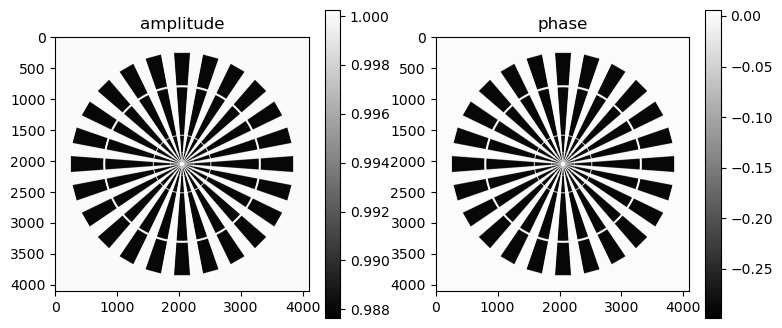

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
im=axs[0].imshow(np.abs(psi[0]),cmap='gray')
axs[0].set_title('amplitude')
fig.colorbar(im)
im=axs[1].imshow(np.angle(psi[0]),cmap='gray')
axs[1].set_title('phase')
fig.colorbar(im)

In [6]:
prb = np.ones([ndist,nz,n],dtype='complex64')

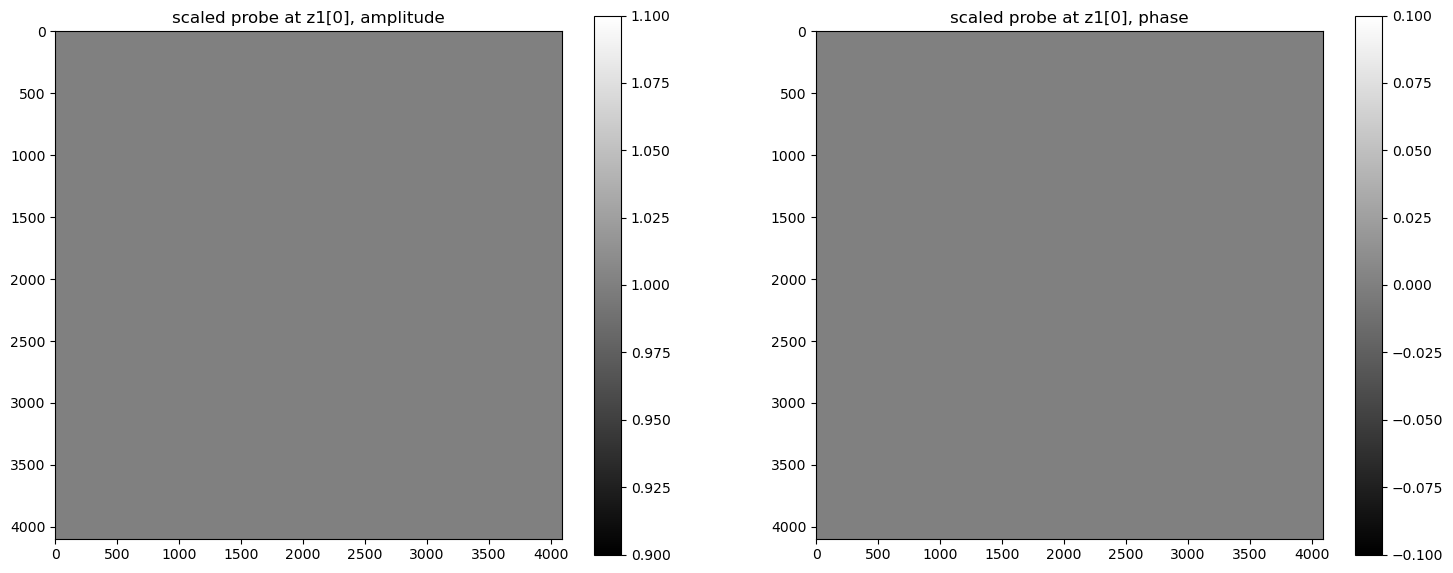

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(18, 7))
im=axs[0].imshow(np.abs(prb[0]),cmap='gray')
axs[0].set_title('scaled probe at z1[0], amplitude')
fig.colorbar(im)
im=axs[1].imshow(np.angle(prb[0]),cmap='gray')
axs[1].set_title('scaled probe at z1[0], phase')
fig.colorbar(im)

## Create a solver class for holography, note the class has additional parameters distances2 to be able to compute Fresnel propagation between the sample and probe

In [8]:
pslv = holotomo.SolverHolo(1, nz, n, 1, voxelsize, energy, distances, norm_magnifications) 


## Model data

In [9]:
fpsi = pslv.fwd_holo_batch(psi,prb)
fflat = pslv.fwd_holo_batch(psi*0+1,prb)

## Take squared absolute value to simulate data on the detector, flat fields, and data with homogeneous flat fields  

In [10]:
data = np.abs(fpsi)**2
flat = np.abs(fflat)**2

## Show data and flat fields for different dists

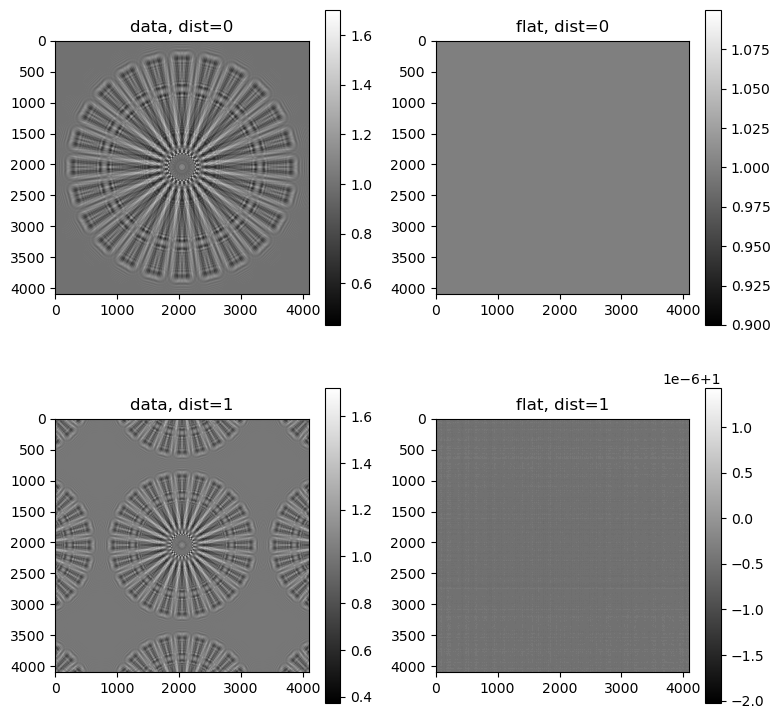

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(9, 9))
im=axs[0,0].imshow(data[0,0],cmap='gray')
axs[0,0].set_title('data, dist=0')
fig.colorbar(im)
im=axs[0,1].imshow(flat[0,0],cmap='gray')
axs[0,1].set_title('flat, dist=0')
fig.colorbar(im)
im=axs[1,0].imshow(data[-1,0],cmap='gray')
axs[1,0].set_title('data, dist=1')
fig.colorbar(im)
im=axs[1,1].imshow(flat[1,0],cmap='gray')
axs[1,1].set_title('flat, dist=1')
fig.colorbar(im)


# Save data and flat fields

In [12]:
for k in range(ndist):
    dxchange.write_tiff(data[k],f'data/modeling/data_siemens_{n}_{k}',overwrite=True)
for k in range(ndist):
    dxchange.write_tiff(flat[k,0],f'data/modeling/flat_siemens_{n}_{k}',overwrite=True)